In [15]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy

In [73]:
pressure = '500'
nc = Dataset('data/sandy/ERA5-sandy-pl_'+pressure+'hpa.nc')

In [74]:
itime = 0 #choose index of time

u = nc.variables['u'][itime, 0, :, :]*1.94384 #result is 2d array (lat, lon), convert to knots
v = nc.variables['v'][itime, 0, :, :]*1.94384
spd = np.sqrt(u**2 + v**2)
lat, lon = np.meshgrid(nc.variables['latitude'][:], nc.variables['longitude'][:], indexing='ij') #make 2d lat, lon grid to match u, v size

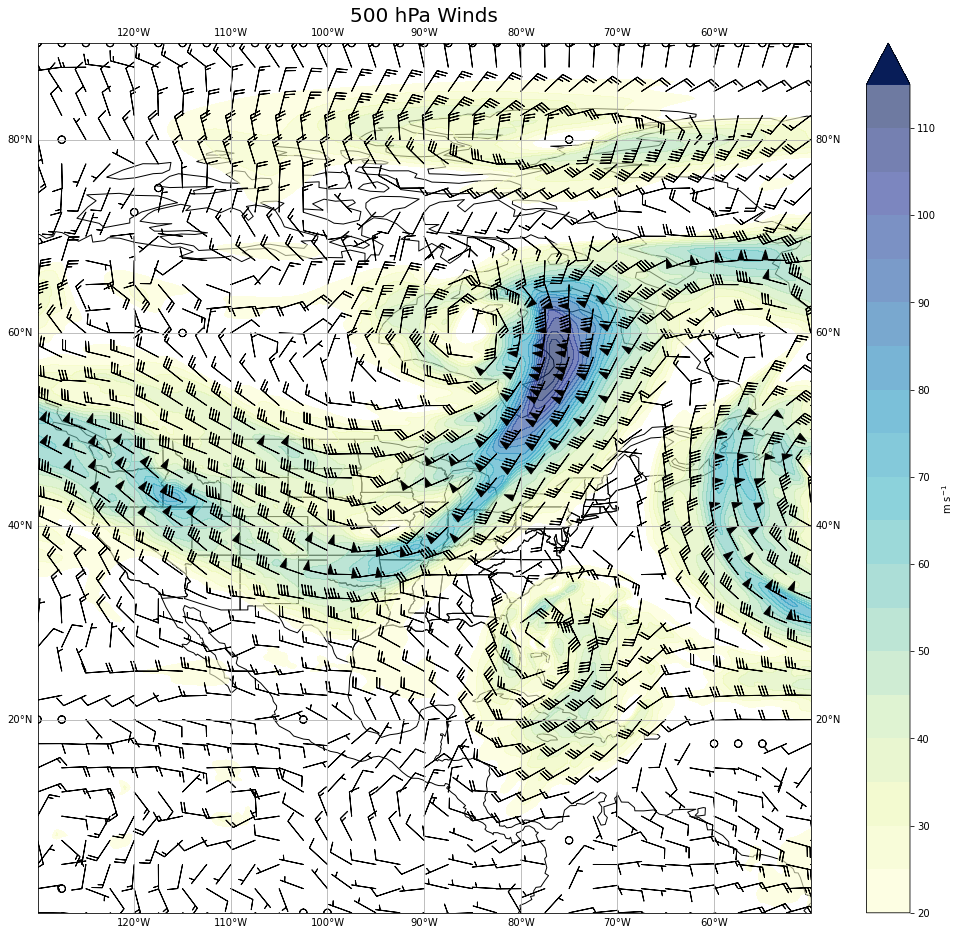

In [75]:
spacing=10 #barbspacing (smaller if zoomed in)

#create figure
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(pressure + ' hPa Winds', fontsize=20)

#contour and barbs
im = ax.contourf(lon, lat, np.sqrt(u**2 + v**2), np.arange(20, np.nanmax(spd), 5), cmap='YlGnBu', alpha=0.6, extend='max',projection=cartopy.crs.PlateCarree(), zorder=2)
cbar = plt.colorbar(im, ax=ax); cbar.ax.set_ylabel('m s$^{-1}$')
ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], u[::spacing,::spacing], v[::spacing,::spacing], zorder=2)

#add map features
#ax.add_feature(cartopy.feature.LAND) #land color
#ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#ax.set_extent([-90, -60, 15, 45]) #Zoomed into Sandy

plt.show()